## Population Segmentation with SageMaker
The question to be answered in this workflow is to find out which US counties have similar characteristics and what kind of features define that similarity

Population segmentation seeks to find natural groupings in population data which reveal feature-level similarities between different regions in the US

Two unsupervised learning algorithms will be employed in this notebook.
- Principal component analysis (PCA) will be used to reduce the dimensionality of the original census data.
- k-means clustering will be used to assign each US county to a particular cluster based on where a county lies in component space

## US Census Data
US Census data obtained from https://data.census.gov/cedsci/, which aims to count the US population, recording demographic traits about labor, age, population, mode of transportation, employement, income etc for each county in the US

## Machine Learning Workflow
The following steps will be followed to implement the population segmentation

- Data loading and exploration
- Data cleaning and pre-processing
- Dimensionality reduction with PCA
- Feature engineering and data transformation
- Clustering transformed data with k-means
- Extracting trained model attributes and visualizing k clusters

In [1]:
# Relevant libraries for this project

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [2]:
# Import the relavant SageMaker libraries
import boto3
import sagemaker

## Loading the Data from Amazon S3

The dataset is also in an Amazon S3 bucket which can be loaded directly by pointing to amazon S3 using the 'boto3' client 


In [3]:
# boto3 client to get the data in s3
s3_client = boto3.client('s3')
bucket_name='aws-ml-blog-sagemaker-census-segmentation'

## View the contents of the bucket


In [4]:
# retrieve contents in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print the objects in the S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['Census_Data_for_SageMaker.csv']


In [5]:
# confirm the file in there and print it
file_name=files[0]

print(file_name)

Census_Data_for_SageMaker.csv


Get the actual census data file from the bucket by using a call to client.get_object()

In [6]:
# get an S3 object by passing in the bucket and file name
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

# show the information contained in the object
display(data_object)

{'ResponseMetadata': {'RequestId': '6873AD3B644F5AFC',
  'HostId': 'jj5sGZ8un3hYb3sLpASF8zTVgCCw0ZqRu0eE/TmHdmIGG0i9tI8BP3wHhEDW2KGgKalJDDwQDd8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'jj5sGZ8un3hYb3sLpASF8zTVgCCw0ZqRu0eE/TmHdmIGG0i9tI8BP3wHhEDW2KGgKalJDDwQDd8=',
   'x-amz-request-id': '6873AD3B644F5AFC',
   'date': 'Mon, 29 Jun 2020 02:37:42 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '613237',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f01c028f3c8>}

In [7]:
# The census information can be found in the "Body" of the object and check out the data type
data_body = data_object["Body"].read()
print('Data type of body: ', type(data_body))

Data type of body:  <class 'bytes'>


In [8]:
# Since the data type is bytes, read in the bytes data using io.bytesIO
data_read = io.BytesIO(data_body)

In [9]:
# create a dataframe
counties_df = pd.read_csv(data_read, header=0, delimiter=",") 
counties_df.head(10)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
5,1011,Alabama,Bullock,10678,5660,5018,4.4,22.2,70.7,1.2,...,5.0,1.7,2.8,27.5,3865,79.5,15.1,5.4,0.0,18.0
6,1013,Alabama,Butler,20354,9502,10852,1.2,53.3,43.8,0.1,...,0.8,0.6,1.7,24.6,7813,77.4,16.2,6.2,0.2,10.9
7,1015,Alabama,Calhoun,116648,56274,60374,3.5,73.0,20.3,0.2,...,1.2,1.2,2.7,24.1,47401,74.1,20.8,5.0,0.1,12.3
8,1017,Alabama,Chambers,34079,16258,17821,0.4,57.3,40.3,0.2,...,0.3,0.4,2.1,25.1,13689,85.1,12.1,2.8,0.0,8.9
9,1019,Alabama,Cherokee,26008,12975,13033,1.5,91.7,4.8,0.6,...,0.6,0.7,2.5,27.4,10155,73.1,18.5,7.9,0.5,7.9


## Exploratory Data Analysis (EDA)

- clean up the data
- explore the data
- pre-process the data

Doing the above will reveal any initial patterns in the data distribution and features. This can show how to proceed with the data modeling and clustering the data.

In [10]:
# Print out the original shape of the data
print('Original rows, columns: ', counties_df.shape)

Original rows, columns:  (3220, 37)


In [11]:
# drop incomplete rows and create a new dataframe
cleaned_counties_df = counties_df.dropna(axis=0)
print ('Cleaned rows, columns: ', cleaned_counties_df.shape)

Cleaned rows, columns:  (3218, 37)


### Reformat the data such that it is indexed by region and drop non-meaningful demographic information

Since machine learning models require numerical data to learn from, it is a must to convert the categorical data to numerical data. Also,a region can be created by combining a state and county to form 'state-county' columns

In [13]:
cleaned_counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [14]:
cleaned_counties_df.describe()

,CensusId,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3.218000e+03,3.218000e+03,3.218000e+03,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3.218000e+03,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,31393.444065,9.947107e+04,4.892729e+04,5.054378e+04,11.006029,75.451243,8.670883,1.720603,1.223244,0.071815,...,3.310534,1.609105,4.628713,23.282474,4.562182e+04,74.235643,17.543350,7.932846,0.288285,8.094779
std,16291.853976,3.193951e+05,1.567252e+05,1.627076e+05,19.242390,22.922274,14.281924,7.252676,2.610159,0.393455,...,3.699291,1.654761,3.173193,5.596578,1.497417e+05,7.817393,6.458126,3.914249,0.455222,4.093038
min,1001.000000,2.670000e+02,1.360000e+02,1.310000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.900000,1.660000e+02,29.500000,5.800000,0.000000,0.000000,0.000000
25%,19033.500000,1.122525e+04,5.657750e+03,5.574250e+03,1.900000,64.100000,0.500000,0.100000,0.200000,0.000000,...,1.400000,0.900000,2.700000,19.500000,4.562000e+03,70.500000,13.100000,5.400000,0.100000,5.500000
50%,30024.000000,2.607950e+04,1.294700e+04,1.306300e+04,3.900000,84.100000,1.900000,0.300000,0.500000,0.000000,...,2.400000,1.300000,3.900000,23.000000,1.052200e+04,75.700000,16.200000,6.900000,0.200000,7.600000
75%,46104.500000,6.645750e+04,3.299825e+04,3.352250e+04,9.800000,93.200000,9.600000,0.600000,1.200000,0.000000,...,4.000000,1.900000,5.600000,26.800000,2.864425e+04,79.700000,20.500000,9.400000,0.300000,9.900000
max,72153.000000,1.003839e+07,4.945351e+06,5.093037e+06,99.900000,99.800000,85.900000,92.100000,41.600000,11.100000,...,71.200000,39.100000,37.200000,44.000000,4.635465e+06,88.300000,66.200000,36.600000,9.800000,36.500000


In [15]:
# index the data by State-County
cleaned_counties_df.index=cleaned_counties_df['State'] + "-" + cleaned_counties_df['County']
cleaned_counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [17]:
# drop the CensusId column which is redundant and the old State and County columns
drop = ['CensusId', 'State', 'County']
cleaned_counties_df = cleaned_counties_df.drop(columns=drop)
cleaned_counties_df.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [18]:
# check out the features being worked with
features_list = cleaned_counties_df.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## Visualizing the Data

A **histogram** can be used to show the distribution of data points over discrete feature ranges. The x-axis represents the different bins and the y-axis is the frequency of occurrence of county data points that fall into each bin.

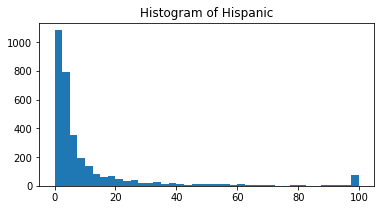

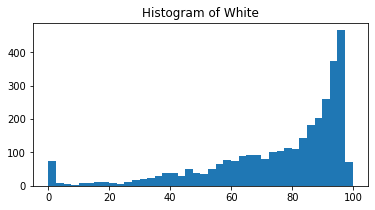

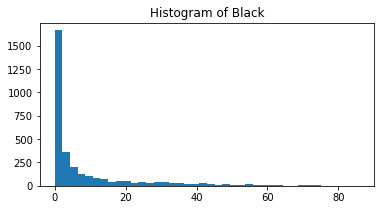

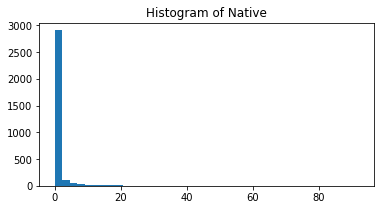

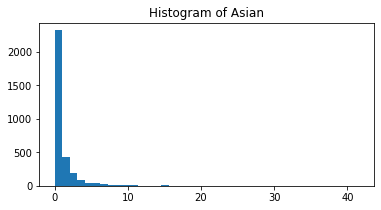

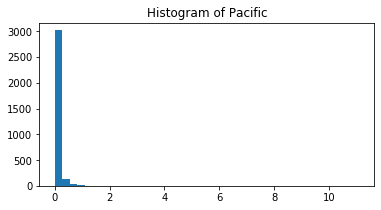

In [19]:
# Plotting a histogram to compare the ethnicities all over the counties.
ethnicity = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
n_bins = 40 # define the size of the bins

# histogram creation code is similar to above
for ethnic in ethnicity:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name(ethnicity) and display a histogram
    ax = plt.hist(cleaned_counties_df[ethnic], bins=n_bins)
    title="Histogram of " + ethnic
    plt.title(title, fontsize=12)
    plt.show()

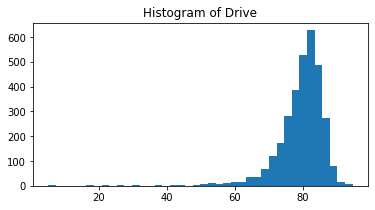

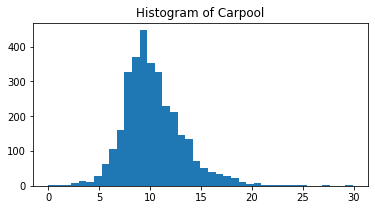

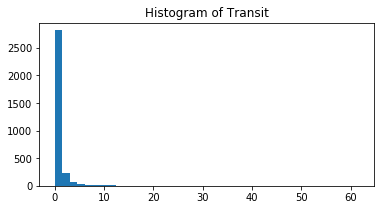

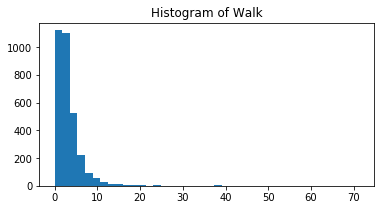

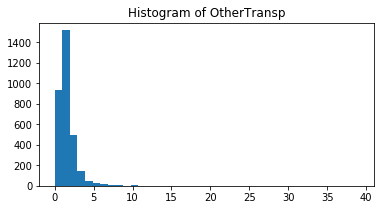

In [20]:
# Plotting a histogram to compare the methods of commuting to work over all of the counties.
# transportation
transport_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']
n_bins = 40 # define the size of the bin

for transportation in transport_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name(transportation) and display a histogram
    ax = plt.hist(cleaned_counties_df[transportation], bins=n_bins)
    title="Histogram of " + transportation
    plt.title(title, fontsize=12)
    plt.show()

## Normalize the data
This is to make sure feature measurements are comparable and consistent. A 'MinMax Scaler' can be used to transform all the numerical values so that they all fall between 0 and 1

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

# define a new df
counties_scaled = pd.DataFrame(scaler.fit_transform(cleaned_counties_df.astype(float)))

# get the same features and state-county indices
counties_scaled.columns = cleaned_counties_df.columns
counties_scaled.index=cleaned_counties_df.index

counties_scaled.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,...,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,...,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


In [22]:
# check the normalized data
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---
# Data Modeling

Feed the data into the machine learning model.

Since some features are not as important as others, it is good to find the features that help to separate and group data, features that cause the **most variance** in the dataset.

Thus a dimensionality reduction step will be taking next, specifically using PCA or **principal component analysis** for this job

## Dimensionality Reduction
PCA transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on. PCA therefore reduces the number of features within a dataset while retaining the principal components.

Hence, it takes many features and combine similar or redundant features together to form a new, smaller feature set.

SageMaker has a built in model for PCA.

### Roles and Buckets

To create a model in SageMaker, an IAM role must be specified(to manage permissions), and to save the model attributes, an S3 bucket must be used to store them.

The `get_execution_role` function is used to retrieved the IAM role

In [23]:
from sagemaker import get_execution_role

# store this current SageMaker session
session = sagemaker.Session()

# retrive an IAM role
role = get_execution_role()
print(role)

arn:aws:iam::915324723064:role/service-role/AmazonSageMaker-ExecutionRole-20200620T221100


In [24]:
# get default bucket which automatically creates a default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-2-915324723064



## The PCA Model

SageMaker has a built-in resource to create the PCA model and it requires the following constructor arguments:

- role: The IAM role, which was specified, above.
- train_instance_count: The number of training instances (typically, 1).
- train_instance_type: The type of SageMaker instance for training.
- num_components: An integer that defines the number of PCA components to produce.
- sagemaker_session: The session used to train on SageMaker.

Documentation on the PCA model can be found [here](http://sagemaker.readthedocs.io/en/latest/pca.html).

In [25]:
# define the location to save model artifacts or training data
prefix = 'counties'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts are stored at: {}'.format(output_path))

Training artifacts are stored at: s3://sagemaker-us-east-2-915324723064/counties/


In [26]:
# define the PCA model
from sagemaker import PCA

N_COMPONENTS=33
pca_model = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path,
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


## Convert data into a RecordSet format

The *record_set* function in the SageMaker PCA model converts a numpy array into a **RecordSet** format. This is a requirement for SageMaker's built-in models. It makes training in SageMaker faster.

In [27]:
# convert the dataframe to np array
train_data_np_array = counties_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_model.record_set(train_data_np_array)

## Train the model
Use the fit function on the PCA model and pass in the RecordSet formatted training data to start a training job

In [28]:
%%time

# train the PCA model
pca_model.fit(formatted_train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-06-29 03:08:10 Starting - Starting the training job...
2020-06-29 03:08:12 Starting - Launching requested ML instances......
2020-06-29 03:09:41 Starting - Preparing the instances for training......
2020-06-29 03:10:20 Downloading - Downloading input data...
2020-06-29 03:10:52 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/29/2020 03:11:15 INFO 140518002468672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[06/29/2020 03:11:15 INFO 140518002468672] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size': u'500', u'num_components

## Accessing the PCA Model Attributes

Access the underlying model parameters.

In [29]:
# Get the name of the training job which can be found on the SageMaker console

training_job_name='pca-2020-06-29-03-08-10-560'

# location of saved model
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip the model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzip the compressed file and store as model_1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

counties/pca-2020-06-29-03-08-10-560/output/model.tar.gz


2304

MXNet can be used to load the stored model artifacts. MXNet is used by many SageMaker algorithms for computational speed.

Documentation for MXNet: [documentation, here](https://aws.amazon.com/mxnet/).

In [31]:
import mxnet as mx

# load the unzipped model artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# show the params
print(pca_model_params)

{'s': 
[1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
 1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
 1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
 2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
 4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
 5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
 1.1718245e+01 1.3035975e+01 1.9592180e+01]
<NDArray 33 @cpu(0)>, 'v': 
[[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
   1.59879066e-02  5.04589686e-03]
 [-2.80601848e-02 -6.86634064e-01 -1.96283013e-02 ... -7.59587288e-02
   1.57304872e-02  4.95312130e-03]
 [ 3.25766727e-02  7.17300594e-01  2.40726061e-02 ... -7.68136829e-02
   1.62378680e-02  5.13597298e-03]
 ...
 [ 1.12151138e-01 -1.17030945e-02 -2.88011521e-01 ...  1.39890045e-01
  -3.09406728e-01 -6.34506866e-02]
 [ 2.99992133e-02 -3.13433539e-03 -7.63589665e-02 ...  4.17341813e-02


## PCA Model Attributes

There are three model attributes within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components.
* **s**: The singular values of the components for the PCA transformation.

**s** can be used to get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

**v** can be used to learn more about the combinations of original features that make up each principal component.


In [32]:
# get the selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

## Data Variance

The PCA model so far has 33 principal components, but only a few selected top n components will be used when a new dimentionality-reduces training data is created.

The **Data variance** will determine the components capture will be used to decide the number of top components to include.

The top principal components that has the largest s values can be found at the end of the s DataFrame. 

In [33]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

            0
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180


###  The explained variance

In creating new training data, the top n principal components must account for at least 80% data variance. 



To calculate the explained variance for the top 5 components, calculate s squared for *each* of the top 5 components, add those up and normalize by the sum of *all* squared s values, according to this formula:

\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}

> This function can be used to answer the **question**: What is the smallest number of principal components that captures at least 80% of the total variance in the dataset?

In [36]:
# Calculate the explained variance for the top n principal components
# Assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  # example 33-5=28
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]


In [41]:
# test cell
n_top_components = 7 # value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.80167246


Next;
- determine what makes up this (and other components)
- what linear combination of features make these components so influential in describing the spread of the data?


In [42]:
# features
features_list = counties_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## Component Makeup

It is now possible to examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**. The following code shows the feature-level makeup of the first component.


In [43]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comprehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # sort by the largest n_weights
    # weights can be neg/pos and can be sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


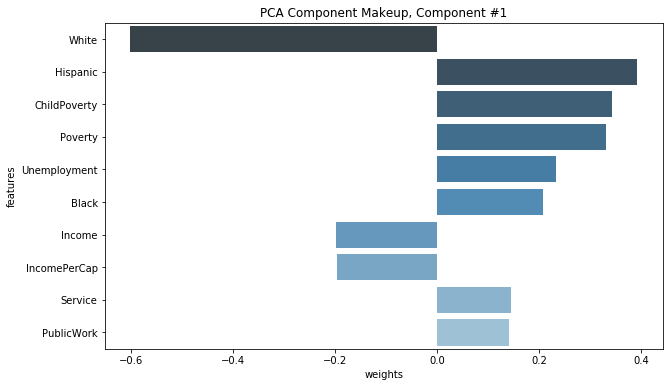

In [44]:
# display makeup of first component
num=1
display_component(v, counties_scaled.columns.values, component_num=num, n_weights=10)

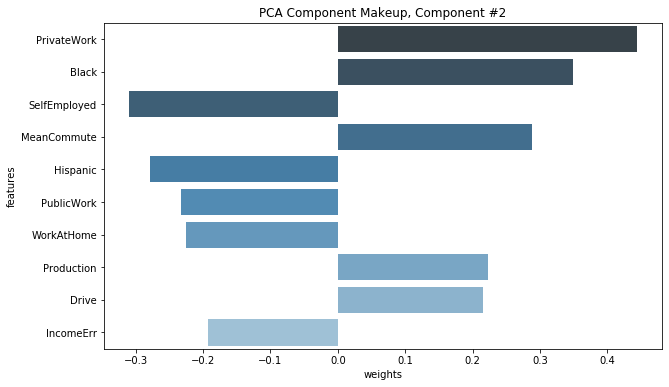

In [45]:
# display makeup of 2nd component
num=2
display_component(v, counties_scaled.columns.values, component_num=num, n_weights=10)

# Deploying the PCA Model

The PCA model can now be used to make "predictions". Actually the training data can be passed into the deployed endpoint to create principal components for each data point. 

In [47]:
%%time
pca_predictor = pca_model.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 281 ms, sys: 4.97 ms, total: 286 ms
Wall time: 7min 32s


In [49]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np_array)

In [50]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.0002009272575378418
      values: 0.0002455431967973709
      values: -0.0005782842636108398
      values: -0.0007815659046173096
      values: -0.00041911262087523937
      values: -0.0005133943632245064
      values: -0.0011316537857055664
      values: 0.0017268601804971695
      values: -0.005361668765544891
      values: -0.009066537022590637
      values: -0.008141040802001953
      values: -0.004735097289085388
      values: -0.00716288760304451
      values: 0.0003725700080394745
      values: -0.01208949089050293
      values: 0.02134685218334198
      values: 0.0009293854236602783
      values: 0.002417147159576416
      values: -0.0034637749195098877
      values: 0.01794189214706421
      values: -0.01639425754547119
      values: 0.06260128319263458
      values: 0.06637358665466309
      values: 0.002479255199432373
      values: 0.10011336207389832
      values: -0.1136140376329422
      values: 0

In [51]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create a dataframe of component features, indexed by State-County
    
    # create new dataframe to add data to
    counties_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        counties_transformed=counties_transformed.append([list(components)])

    # index by county, just like counties_scaled
    counties_transformed.index=counties_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    counties_transformed = counties_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return counties_transformed.iloc[:, ::-1]

### Define the `top_n` components to use in this transformed data


In [52]:
# specify top n
top_n = 7

# call your function and create a new dataframe
counties_transformed = create_transformed_df(train_pca, counties_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7']
counties_transformed.columns=PCA_list 

# print result
counties_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099


### Delete the Endpoint!

The model has been deployed and a new transformed training data has been created, the PCA endpoint is no longer needed.

In [53]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

---
# Population Segmentation 

k-means will now be used to segment counties using their PCA attributes, which are in the transformed DataFrame. K-means is a clustering algorithm that identifies clusters of similar data points based on their component makeup. 

There were ~3000 counties and 34 attributes in the original dataset. Hence the large feature space may have made it difficult to cluster the counties effectively. Instead, the feature space has been reduced to 8 PCA components.

### Define a k-means model

A `KMeans` estimator requires a number of parameters to be instantiated, which allow to specify the type of training instance to use, and the model hyperparameters. 

More about parameters, in the [`KMeans` documentation](https://sagemaker.readthedocs.io/en/stable/kmeans.html)

### Choosing a "Good" K

One method for choosing a "good" k, is to choose based on empirical data. A bad k would be one so *high* that only one or two very close data points are near it, and another bad k would be one so *low* that data points are really far away from the centers.

You want to select a k such that data points in a single cluster are close together but that there are enough clusters to effectively separate the data. You can approximate this separation by measuring how close your data points are to each cluster center; the average centroid distance between cluster points and a centroid. After trying several values for k, the centroid distance typically reaches some "elbow"; it stops decreasing at a sharp rate and this indicates a good value of k.

In [57]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 8

kmeans = KMeans(role=role,
               train_instance_count=1,
               train_instance_type='ml.c4.xlarge',
               output_path=output_path, #same path was defined earlier
               k=NUM_CLUSTERS)

### Create formatted, k-means training data

The `counties_transformed` df must be converted into a numpy array and then into a RecordSet. This is the required format for passing training data into a `KMeans` model.

In [59]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = counties_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

### Train the k-means model

Pass in the formatted training data and train the k-means model.

In [60]:
%%time
# train kmeans
kmeans.fit(kmeans_formatted_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-06-29 03:52:03 Starting - Starting the training job...
2020-06-29 03:52:05 Starting - Launching requested ML instances......
2020-06-29 03:53:06 Starting - Preparing the instances for training......
2020-06-29 03:54:32 Downloading - Downloading input data
2020-06-29 03:54:32 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/29/2020 03:54:47 INFO 140051944888128] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval

### Deploy the k-means model

Deploy the trained model to create a `kmeans_predictor`.


In [61]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!CPU times: user 251 ms, sys: 4.02 ms, total: 255 ms
Wall time: 6min 31s


### Pass in the training data and assign predicted cluster labels

After deploying the model, pass in the k-means training data, as a numpy array, and get resultant, predicted cluster labels for each data point.

In [62]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

## Exploring the resultant clusters

The resulting predictions gives information about the cluster that each data point belongs to.

In [63]:
# print cluster info for first data point
data_idx = 0

print('County is: ', counties_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

County is:  Alabama-Autauga

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 2.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.25010794401168823
    }
  }
}



### Visualize the distribution of data over clusters

Get the cluster labels for each of our data points (counties) and visualize the distribution of points over each cluster.

In [64]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [65]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

0.0    836
1.0    664
2.0    523
6.0    374
5.0    333
4.0    232
7.0    166
3.0     90
Name: 0, dtype: int64


To improve explainability, the underlying model must be accessed to get the cluster centers. These centers will help describe which features characterize each cluster.

### Delete the Endpoint!

the k-means model has been deployed and the cluster labels for each data point has been extracted, hence, the k-means endpoint is no longer needed.

In [66]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

# Model Attributes & Explainability

Explaining the result of the modeling is an important step in making use of the analysis. By combining PCA and k-means, and the information contained in the model attributes within a SageMaker trained model, can reveal some patterns in the population data

### Access the k-means model attributes

Extract the k-means model attributes from where they are saved as a TAR file in an S3 bucket.

Thus, access the model by the k-means training job name, and then unzip the file into `model_algo-1`. Then load the file using MXNet.

In [68]:
# download and unzip the kmeans model file
kmeans_job_name = 'kmeans-2020-06-29-03-52-03-722'
model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# ownload the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [69]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[-0.1941185   0.06759156  0.04730124 -0.08242407 -0.04972722 -0.05966701
  -0.00751055]
 [-0.00583044  0.10195461  0.149561   -0.05258242 -0.00247189  0.06916684
  -0.023074  ]
 [-0.18910468  0.03939097 -0.23785903  0.03586661 -0.0421642   0.05444027
   0.00151794]
 [ 1.3179148  -0.22901893 -0.17191696 -0.42862532 -0.1254275   0.11986868
   0.16373411]
 [ 0.336813   -0.16628762 -0.1532498  -0.14796095  0.13182588 -0.08044827
  -0.05905489]
 [-0.283701   -0.35270354  0.08492585  0.05941944  0.08535364 -0.00186218
   0.09849887]
 [ 0.3750971   0.25563613  0.05339827  0.27874926  0.09740274 -0.05854611
   0.04827948]
 [ 0.16074789 -0.34485716  0.10784703  0.17717521 -0.1358239  -0.00166287
  -0.16403803]]
<NDArray 8x7 @cpu(0)>]


There is only 1 set of model parameters contained within the k-means model: the cluster centroid locations in PCA-transformed, component space.

* **centroids**: The location of the centers of each cluster in component space, identified by the k-means algorithm. 


In [70]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=counties_transformed.columns

display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
0,-0.194118,0.067592,0.047301,-0.082424,-0.049727,-0.059667,-0.007511
1,-0.005830,0.101955,0.149561,-0.052582,-0.002472,0.069167,-0.023074
2,-0.189105,0.039391,-0.237859,0.035867,-0.042164,0.054440,0.001518
3,1.317915,-0.229019,-0.171917,-0.428625,-0.125427,0.119869,0.163734
4,0.336813,-0.166288,-0.153250,-0.147961,0.131826,-0.080448,-0.059055
5,-0.283701,-0.352704,0.084926,0.059419,0.085354,-0.001862,0.098499
6,0.375097,0.255636,0.053398,0.278749,0.097403,-0.058546,0.048279
7,0.160748,-0.344857,0.107847,0.177175,-0.135824,-0.001663,-0.164038


### Visualizing Centroids in Component Space

Plot a heatmap of the centroids and their location in the transformed feature space.

This gives insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA + clustering techniques, together. Since it was possible to examine the makeup of each PCA component, what each centroid represents in terms of the PCA components can be understood.

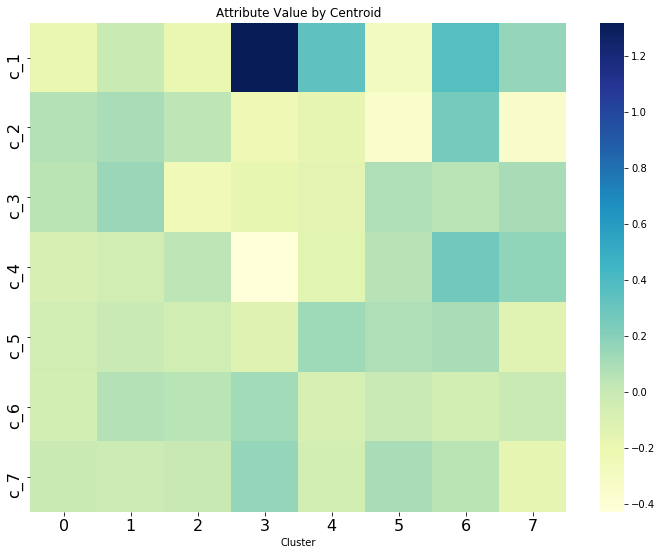

In [71]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

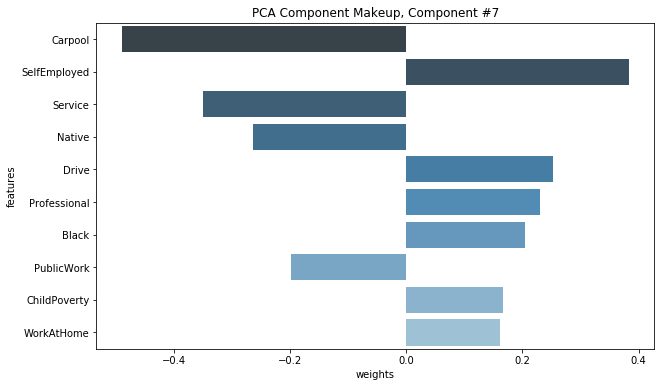

In [72]:
# what do each of these components mean again?
# let's use the display function, from above
component_num=7
display_component(v, counties_scaled.columns.values, component_num=component_num)

### Natural Groupings

The cluster labels can also be mapped back to each individual county and examine which counties are naturally grouped together.

In [73]:
# add a 'labels' column to the dataframe
counties_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_counties = counties_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_counties.head(30)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,labels
Ohio-Portage,-0.196308,0.230008,-0.082434,-0.070200,-0.136106,0.028791,0.002311,0
Tennessee-Washington,-0.156047,0.072384,-0.059869,0.008101,-0.250716,-0.007781,0.118529,0
Indiana-Harrison,-0.261680,0.233852,-0.015319,-0.137624,0.006672,0.110569,-0.032987,0
Indiana-Henry,-0.158191,0.236227,0.085169,-0.130977,-0.103759,0.051218,0.027058,0
Indiana-Howard,-0.105203,0.222032,0.035088,-0.072719,-0.128753,-0.124214,-0.006026,0
Indiana-Huntington,-0.282286,0.222730,0.052914,-0.160062,-0.065343,-0.166231,-0.036551,0
Indiana-Jackson,-0.200640,0.238194,0.029130,-0.198377,-0.032890,-0.162620,-0.018113,0
Indiana-Jasper,-0.307139,0.133769,-0.009029,-0.184680,0.189662,-0.001936,-0.076375,0
Indiana-Jay,-0.200795,0.165554,0.237676,-0.201521,0.045532,-0.156859,0.008112,0
Indiana-Jefferson,-0.185164,0.167541,0.112002,-0.109130,-0.039317,-0.029660,-0.070001,0


It is also possible to examine one of the clusters in more detail, like cluster 1, for example. A quick glance at the location of the centroid in component space (the heatmap) shows that it has the highest value for the `comp_6` attribute.

In [74]:
# get all counties with label == 1
cluster=counties_transformed[counties_transformed['labels']==1]
cluster.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,labels
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053,1
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099,1
Alabama-Calhoun,0.128913,0.223409,0.070180,0.081091,-0.069090,0.002235,0.012866,1
Alabama-Cherokee,-0.080311,0.104444,0.210828,-0.061823,0.027139,0.107847,-0.002206,1
Alabama-Chilton,0.022630,0.240691,0.068429,-0.103816,0.138959,0.141059,-0.052229,1


## Final Cleanup!

* Double check that all endpoint are deleted
* Manually delete the S3 bucket, models, and endpoint configurations directly from the AWS console.

Thorough cleanup instructions can be found here, [in the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html).

# Conclusion

This was a machine learning workflow for unsupervised learning, specifically, for clustering a dataset using k-means after reducing the dimensionality using PCA. By accessing the underlying models created within  SageMaker, the explainability of the model was improved and insights were drawn from the resultant clusters. 

Using these techniques, a better understanding of the essential characteristics of different counties in the US has been gained and was segmented into similar groups, accordingly.